Load dependencies

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from model.module import FlowMatchingModule
from model.cvf import CFGVectorFieldODE
from lightning import LightningModule
from torchdyn.core import NeuralODE
from torch import nn
from torchvision.utils import make_grid

model_path = "path/to/model.ckpt"

### Image Generation Demo

Helper function for loading model

In [4]:
def load_module(model_path: str) -> LightningModule:
    """
    Load the saved model checkpoint for inference
    """
    if not os.path.isfile(model_path):
        raise FileNotFoundError(f'Model checkpoint not found: `{model_path}`.')

    cfm_module = FlowMatchingModule.load_from_checkpoint(
        checkpoint_path=model_path
    )
    cfm_module.eval()
    return cfm_module

Load model from checkpoint

In [ ]:
#load module from run directory
cfm_module = load_module(model_path)
vector_field = cfm_module.model #learned vector field
cond_path = cfm_module.path #Gaussian conditional probability path

Vector field wrapper class to simulate vector field with conditional y (required for compatibility with `torchdyn`)

In [6]:
class VectorFieldWrapper(nn.Module):
    def __init__(self, vf, y):
        super().__init__()
        self.vf = vf
        self.y = y

    def forward(self, t, x, **kwargs): #forward method must accept additional keyword arguments
        return self.vf(x, t.view(1, -1, 1, 1, 1).expand(len(x), -1, 1, 1, 1), self.y)

Sample from simple distribution (Gaussian) and generate images from labels

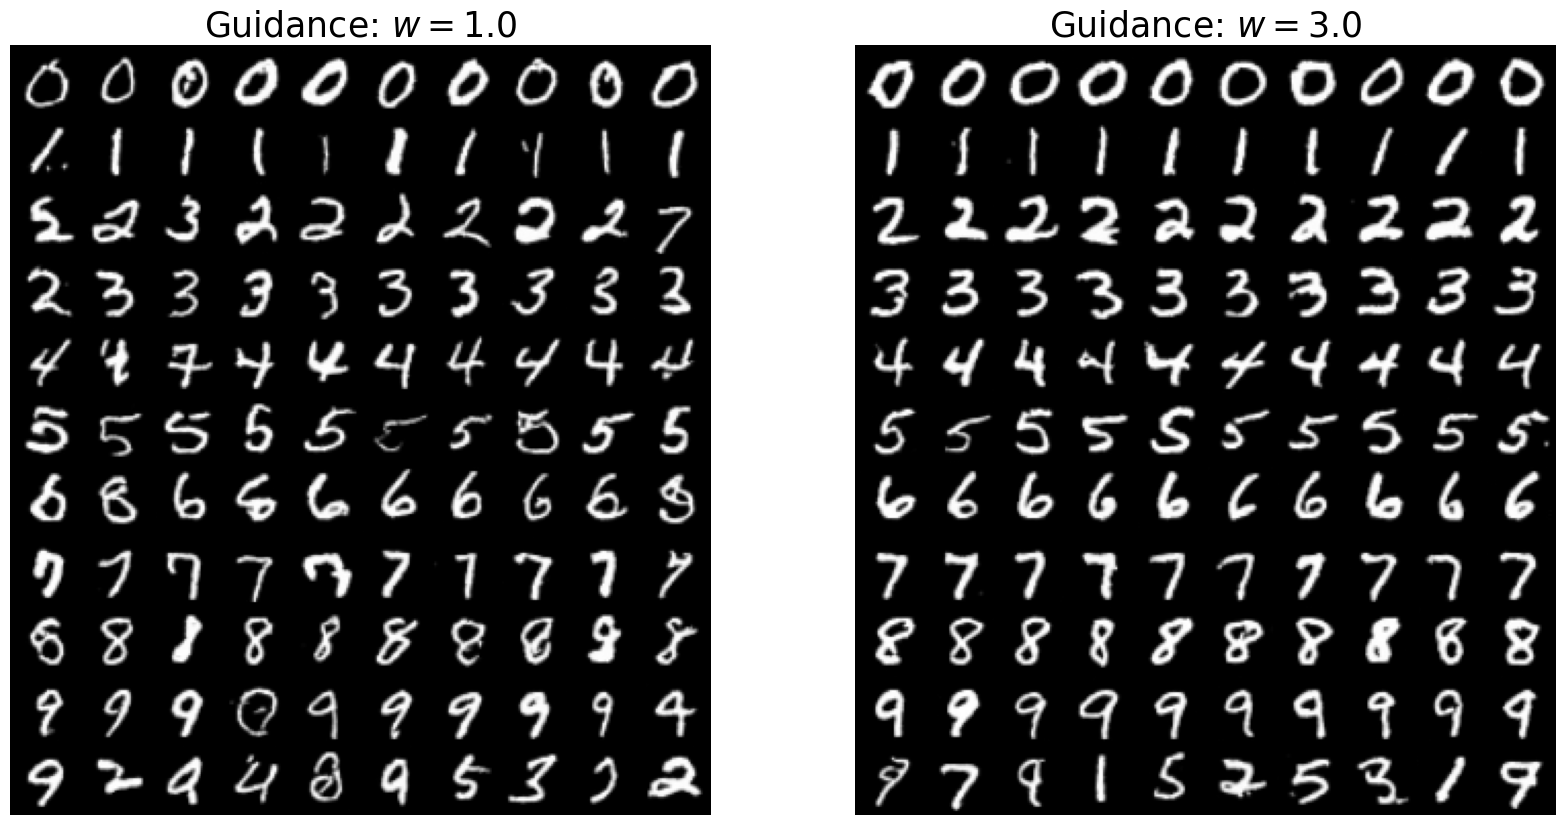

In [7]:
#parameters for generating images
num_timesteps = 20
samples_per_class = 10
guidance_scales = [1.0, 3.0]

fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))

for idx, w in enumerate(guidance_scales):
    #define conditional y to guide vector field
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64, device=cfm_module.device).repeat_interleave(samples_per_class)
    num_samples = len(y)

    #define vector field
    vf_ode = CFGVectorFieldODE(vector_field, w)
    wrapped_vf = VectorFieldWrapper(vf_ode, y)
    flow_ode = NeuralODE(wrapped_vf, sensitivity='adjoint', solver='euler') #try different solvers (euler is fastest)

    #define initial state to simulate
    x0, _ = cond_path.p_simple.sample(num_samples)

    #solve ODE to generate images
    with torch.no_grad():
        traj = flow_ode.trajectory(
            x0,
            t_span=torch.linspace(0, 1, num_timesteps, device=cfm_module.device),
        )

    # Plot
    image_np = traj[-1].squeeze(0) #take the last timepoint of the trajectory
    grid = make_grid(image_np, nrow=samples_per_class, normalize=True, value_range=(-1,1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)